In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [3]:
class LeakyIntegrateAndFireModel:
    def __init__(self, dt, t_init, T, vRest, vTh, tau_ref, vSpike, I, Rm, Cm, Vm = None):
        self.dt = dt  # Time step
        self.t_init = t_init  # Initial time
        self.T = T  # Total simulation time in mSec
        self.vRest = vRest  # Resting potential
        self.vTh = vTh  # Threshold voltage
        self.tau_ref = tau_ref  # Refractory period
        self.vSpike = vSpike  # Spike voltage
        self.I = I  # Input current
        self.Rm = Rm  # Membrane resistance
        self.Cm = Cm  # Membrane capacitance
        self.time = np.arange(0, T*1e-3 + dt*1e-3, dt*1e-3)  # Time array
        self.Vm = np.ones(len(self.time))*vRest*1e-3  # Membrane potential
            
        self.tau_m = self.Rm * 1e3 * self.Cm * 1e-6  # Membrane time constant


    def simulate(self, plot = False):
        # Update the time array based on T and dt
        self.time = np.arange(0, self.T * 1e-3 + self.dt * 1e-3, self.dt * 1e-3) 
        # Triangular stimulation
        self.stim = np.ones(len(self.time)) * float(self.I) * 1e-3
        
        # Array to hold spike times for each set of Rm and Cm values
        spikes = []
        tau_m = self.Rm * 1e3 * self.Cm * 1e-6
        Vm = np.ones(len(self.time)) * self.vRest * 1e-3  # Reset Vm for each simulation
        Vm, spikes = self.simulation_step(self.t_init, self.vRest, self.Rm, self.Cm, tau_m, self.vTh, self.vSpike, self.stim, self.time, Vm)
        if plot == True:
            self.neural_plot(self.time, Vm, self.stim, spikes, self.vTh)
        return Vm, spikes

    def simulation_step(self, t_init, vRest, Rm, Cm, tau_m, vTh, vSpike, stim, time, Vm):
        spikes = []
        for i, t in enumerate(time[:-1]):
            if t > t_init:
                uinf = vRest*1e-3 + Rm*1e3 * stim[i]
                Vm[i+1] = uinf + (Vm[i] - uinf) * np.exp(-self.dt * 1e-3 / tau_m)
                if Vm[i] >= vTh * 1e-3:
                    spikes.append(t * 1e3)
                    Vm[i] = vSpike * 1e-3
                    t_init = t + self.tau_ref * 1e-3
        return Vm, spikes

    def neural_plot(self, time, Vm, stim, spikes, vTh):
        plt.figure(figsize=(10, 5))
        plt.title('Leaky Integrate-and-Fire Model', fontsize=15)
        plt.ylabel('Membrane Potential (mV)', fontsize=15)
        plt.xlabel('Time (msec)', fontsize=15)
        plt.plot(time * 1e3, Vm * 1e3, linewidth=5, label='Vm')
        plt.plot(time * 1e3, 100 / max(stim) * stim, label='Stimuli (Scaled)', color='sandybrown', linewidth=2)
        plt.ylim([-75, 100])
        if spikes:
            plt.axvline(x=spikes[0], c='red', label='Spike')
            for s in spikes[1:]:
                plt.axvline(x=s, c='red')
        plt.axhline(y=vTh, c='black', label='Threshold', linestyle='--')
        plt.legend()
        plt.show()


First Step, try different currents and get subsequent frequencies.

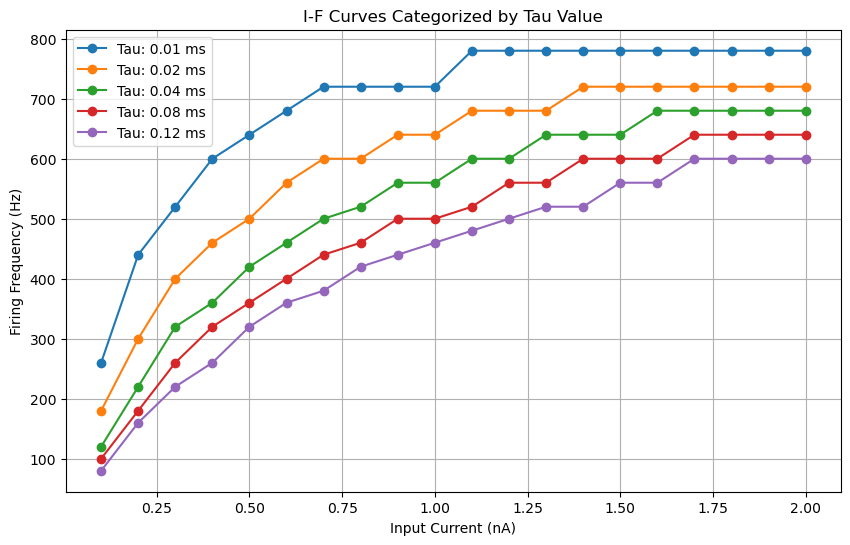

In [4]:
# Initialize the plot
plt.figure(figsize=(10, 6))

# Membrane resistance and capacitance values
Rms = np.array([1, 2, 3, 4, 5])  # Membrane resistance in MOhms
Cms = np.array([5, 10, 15, 20, 25])  # Membrane capacitance in uF

# Calculate tau values
tau_ms = Rms * 1e3 * Cms * 1e-6

# Loop over each Rm and Cm pair
for Rm, Cm, tau in zip(Rms, Cms, tau_ms):
    currents = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
    frequencies = []
    
    # Run simulations for each current
    for current in currents:
        model = LeakyIntegrateAndFireModel(
            dt=0.1, t_init=0, T=50, vRest=-70, vTh=-30, tau_ref=1, vSpike=50, I=current, Rm=Rm, Cm=Cm
        )
        Vm, spikes = model.simulate()
        
        # Calculate firing frequency
        frequency = len(spikes) / (model.T / 1000)  # Convert T to seconds
        frequencies.append(frequency)
    
    # Plotting the I-F curve for this Rm and Cm
    plt.plot(currents, frequencies, marker='o', label=f'Tau: {tau:.2f} ms')

# Finalize the plot
plt.title('I-F Curves Categorized by Tau Value')
plt.xlabel('Input Current (nA)')
plt.ylabel('Firing Frequency (Hz)')
plt.legend()
plt.grid(True)
plt.show()

Now it's time to work on part 2, vary the voltage thresholds

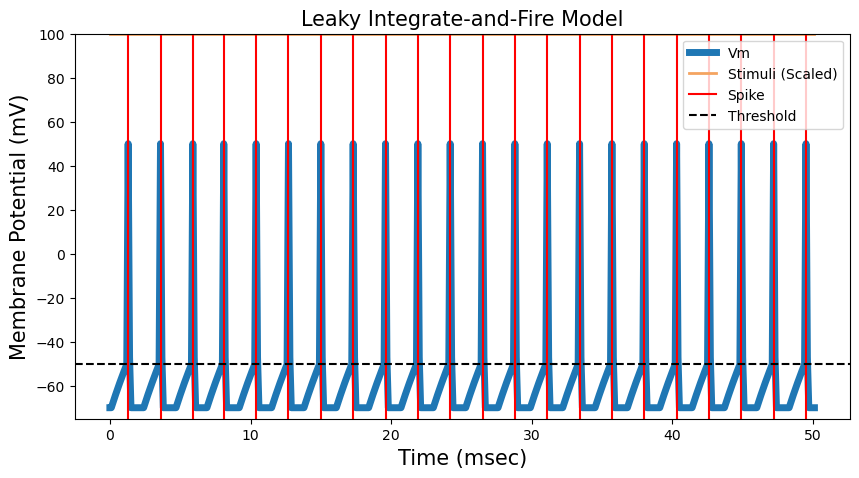

-50
[1.3000000000000003, 3.6000000000000005, 5.8999999999999995, 8.1, 10.400000000000002, 12.700000000000001, 15.000000000000002, 17.3, 19.599999999999998, 21.9, 24.200000000000003, 26.500000000000004, 28.800000000000004, 31.1, 33.4, 35.7, 38.0, 40.300000000000004, 42.6, 44.900000000000006, 47.199999999999996, 49.5]


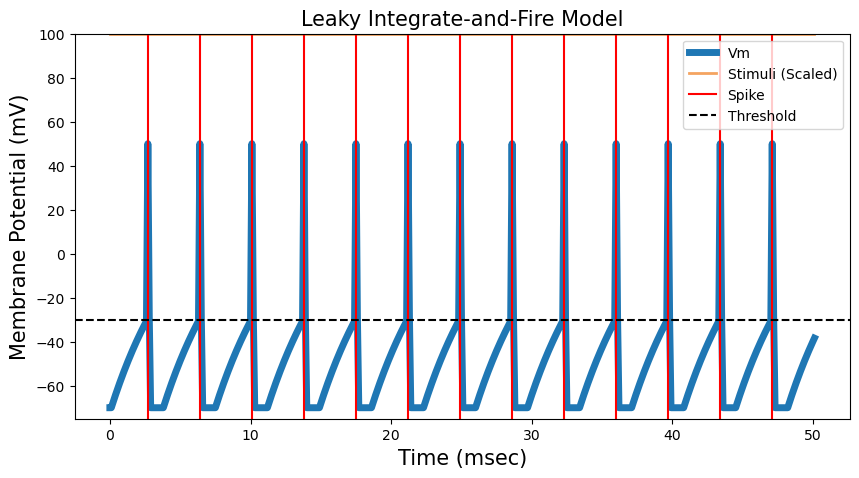

-30
[2.7, 6.4, 10.100000000000001, 13.8, 17.5, 21.2, 24.900000000000002, 28.6, 32.300000000000004, 36.00000000000001, 39.699999999999996, 43.4, 47.1]


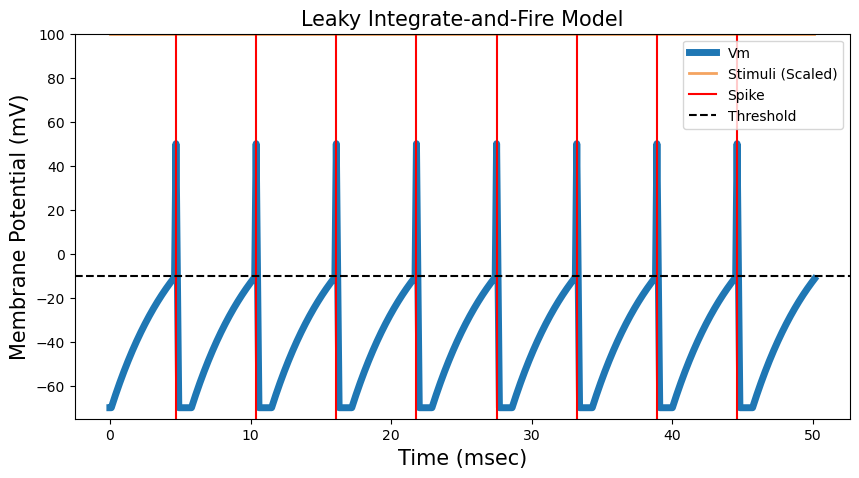

-10
[4.7, 10.400000000000002, 16.1, 21.8, 27.5, 33.2, 38.900000000000006, 44.6]


In [30]:
Vms = np.array([-50, -30, -10])

# Run simulations for each current
for Vm in Vms:
    model = LeakyIntegrateAndFireModel(
        dt=0.1, t_init=0, T=50, vRest=-70, vTh=Vm, tau_ref=1, vSpike=50, I=0.1, Rm=1, Cm=5, Vm = Vm
    )
    Vs, spikes = model.simulate(plot=True)
    print(Vm)
    print(spikes)

In [37]:
import numpy as np

def calculate_time_to_threshold(vTh, vRest, Rm, I, Cm):
    """
    Calculate the time it takes for the membrane potential to reach the threshold
    from the resting potential given a constant input current, adjusting for the
    parameters and units provided in the LeakyIntegrateAndFireModel.
    
    Arguments:
    vTh : float -- Spike threshold (mV).
    vRest : float -- Resting potential (mV).
    Rm : float -- Membrane resistance (kOhm).
    I : float -- Constant input current (mA).
    Cm : float -- Membrane capacitance (uF).
    
    Returns:
    T : float -- Time taken to reach the threshold (msec).
    """
    # Convert units: V to mV, R to Ohms, I to A, and tau_m calculation includes conversion from sec to msec
    V_th = vTh * 1e-3  # mV to V
    V_rest = vRest * 1e-3  # mV to V
    R_m = Rm * 1e3  # kOhm to Ohm
    I_e = I * 1e-3  # mA to A
    tau_m = R_m * (Cm * 1e-6) * 1e3  # kOhm*uF to sec, then to msec
    
    T = -tau_m * np.log(1 - (V_th - V_rest) / (R_m * I_e))
    return T

# Model parameters from LeakyIntegrateAndFireModel instantiation
vTh = -50  # Spike threshold (mV)
vRest = -70  # Resting potential (mV)
Rm = 1  # Membrane resistance (kOhm)
I = 0.2  # Assuming 'current' is your input current in mA
Cm = 5  # Membrane capacitance (uF)

# Calculate the time to threshold
T = calculate_time_to_threshold(vTh, vRest, Rm, I, Cm)
print("Time to reach threshold:", T, "msec")

Time to reach threshold: 0.5268025782891314 msec
